In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

# Data Preprocessing

In [54]:
def load_and_preprocess_data(source: str, target_col: str) -> pd.DataFrame:
    df = pd.read_csv(source, parse_dates=['Unnamed: 0'])
    df.rename(columns={'Unnamed: 0': 'date'}, inplace=True)
    df = df.sort_values('date')
    
    # Drop target variable NaN values
    df.dropna(subset=[target_col], inplace=True)

    # Remove outliers using z-score for numerical columns
    # numeric_cols = df.select_dtypes(include=[np.number]).columns
    # df = df[(np.abs((df[numeric_cols] - df[numeric_cols].mean()) / df[numeric_cols].std()) < 3).all(axis=1)]

    return df

# Feature Engineering

In [ ]:
def create_features(df: pd.DataFrame, target_col: str) -> pd.DataFrame:
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['rolling_mean_3'] = df[target_col].rolling(window=3).mean()
    df['rolling_std_3'] = df[target_col].rolling(window=3).std()
    return df

# Data Split

In [56]:
def split_data(df: pd.DataFrame, target_col: str, test_size: float = 0.2) -> tuple:
    X = df.drop(columns=[target_col, 'date', 'MORTGAGE30US'])
    y = df[target_col]
    return train_test_split(X, y, test_size=test_size, shuffle=True)

# Training

In [57]:
def train_model(X_train, y_train):
    model = RandomForestRegressor(n_estimators=400, random_state=42)

    # model = xgb.XGBRegressor(
    #     n_estimators=400,
    #     learning_rate=0.2,
    #     max_depth=10,
    #     min_child_weight=9,
    #     random_state=42
    #     )
    
    model.fit(X_train, y_train)
    return model

# Hyperparameter Tuning

In [58]:
def tune_hyperparameters(model, X_train, y_train):
    hyperparameter_grid = {
        'n_estimators': [100, 400, 800],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.05, 0.1, 0.20],
        'min_child_weight': [1, 10, 100]
        }
    
    # Create the GridSearchCV object
    grid_search = GridSearchCV(model, hyperparameter_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

    # Fit the GridSearchCV object to the training data
    grid_search.fit(X_train, y_train)

    # Print the best set of hyperparameters and the corresponding score
    print("Best set of hyperparameters: ", grid_search.best_params_)
    print("Best score: ", grid_search.best_score_)

# Evaluation

In [59]:
def evaluate_model(model, X_test, y_test):
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    print(f"RMSE: {rmse:.4f}%, MAE: {mae:.4f}%, R2: {r2:.4f}")
    return preds

# Forecast

In [68]:
def forecast_next_week(model, df: pd.DataFrame, target_col: str):
    last_row = df.iloc[-1:]
    last_rate = last_row['MORTGAGE30US'].values[0]
    features = last_row.drop(columns=[target_col, 'date', 'MORTGAGE30US'])
    prediction = model.predict(features) + last_rate
    print(f"Forecasted {target_col} for next week: {prediction[0]:.4f}")
    return prediction[0]

# Visualization

In [61]:
def plot_predictions(dates, y_test, preds, forecasted_value=None):
    plt.figure(figsize=(12,6))
    plt.plot(dates, y_test, label='Actual')
    plt.plot(dates, preds, label='Predicted')
    if forecasted_value is not None:
        plt.scatter(dates.iloc[-1] + pd.DateOffset(weeks=1), forecasted_value, color='red', zorder=5, label='Forecasted Next Week')
    plt.xlabel('Date')
    plt.ylabel('Rate')
    plt.title('Actual vs Predicted 30Y Fixed Mortgage Rate')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_feature_importance(model, feature_names):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(10, 6))
    plt.title("Feature Importances")
    sns.barplot(x=importances[indices], y=np.array(feature_names)[indices])
    plt.tight_layout()
    plt.show()

def plot_scatter_predictions(y_test, preds):
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=y_test, y=preds)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Scatter plot of Actual vs Predicted')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_error_distribution(y_test, preds):
    errors = y_test - preds
    plt.figure(figsize=(10, 6))
    sns.histplot(errors, bins=30, kde=True)
    plt.xlabel('Prediction Error')
    plt.title('Distribution of Prediction Errors')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Run Pipeline

In [70]:
# Run pipeline
target_col = 'MORTGAGE30US_diff'

df = load_and_preprocess_data('../data/full_mortgage_dataset.csv', target_col)
df = create_features(df, target_col)
X_train, X_test, y_train, y_test = split_data(df, target_col, test_size=0.2)
test_dates = df.loc[X_test.index, 'date']

model = train_model(X_train, y_train)
preds = evaluate_model(model, X_test, y_test)

forecasted_value = forecast_next_week(model, df, target_col)

Features:  ['date', 'MORTGAGE30US', 'DGS10', 'FEDFUNDS', 'CPIAUCSL', 'UNRATE', 'GDP', 'FIXHAI', 'HOUST', 'PERMIT', 'DFF', 'M2SL', 'M1SL', 'M1V', 'M2V', 'M3SL', 'M2REAL', 'M1REAL', 'PAYEMS', 'CIVPART', 'JTSJOL', 'PCEPI', 'CPILFESL', 'PPIACO', 'SPCS20RSA', 'MSPUS', 'GDPC1', 'GNPCA', 'A939RC0Q052SBEA', 'EXPGS', 'IR14240', 'BOPGSTB', 'TOTRESNS', 'BUSLOANS', 'RETAILSMSA', 'UMCSENT', 'USEPUINDXD', 'MBS', '^VIX', 'TLT', '^GSPC', 'FNMA', 'Zillow_HPI', 'MORTGAGE30US_diff', 'Month', 'MORTGAGE30US_1', 'MORTGAGE30US_2', 'MORTGAGE30US_4', 'MORTGAGE30US_8', 'year', 'month', 'weekofyear', 'rolling_mean_3', 'rolling_std_3']
RMSE: 0.0886%, MAE: 0.0593%, R2: 0.2913
Forecasted MORTGAGE30US_diff for next week: 6.8512


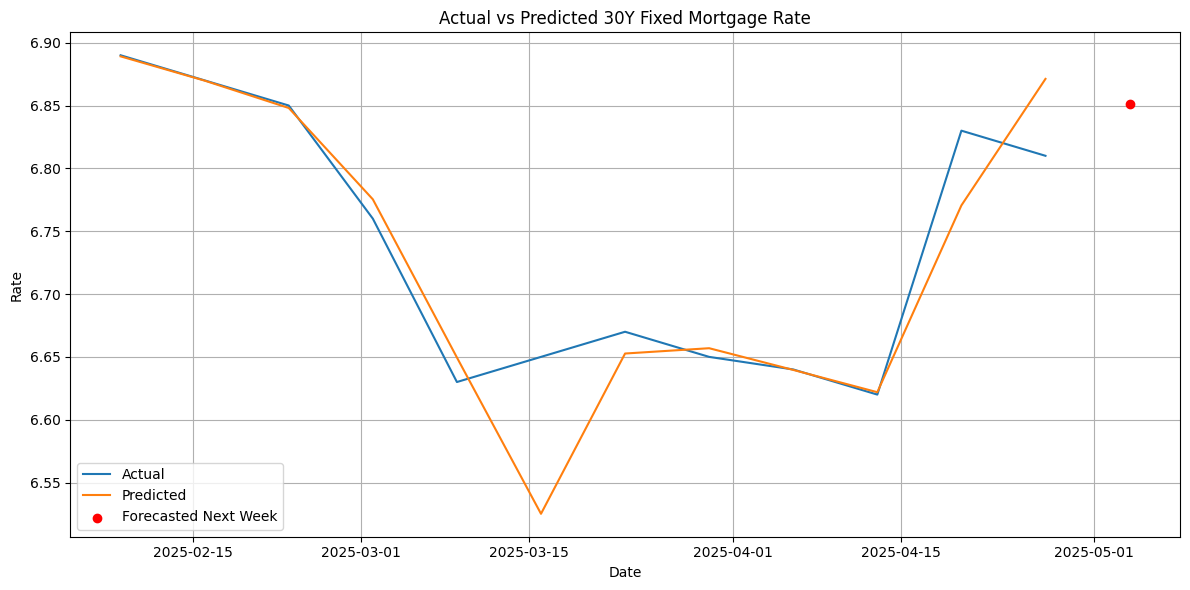

In [72]:
# Plot predictions of last 3 months and the forecasted value
latest_dates = df['date'].iloc[-12:]
latest_y_test = df['MORTGAGE30US'].iloc[-12:]

latest_features = df.drop(columns=[target_col, 'date', "MORTGAGE30US"]).iloc[-12:]
latest_preds = model.predict(latest_features) + df['MORTGAGE30US'].iloc[-13:-1].values

plot_predictions(latest_dates, latest_y_test, latest_preds, forecasted_value)

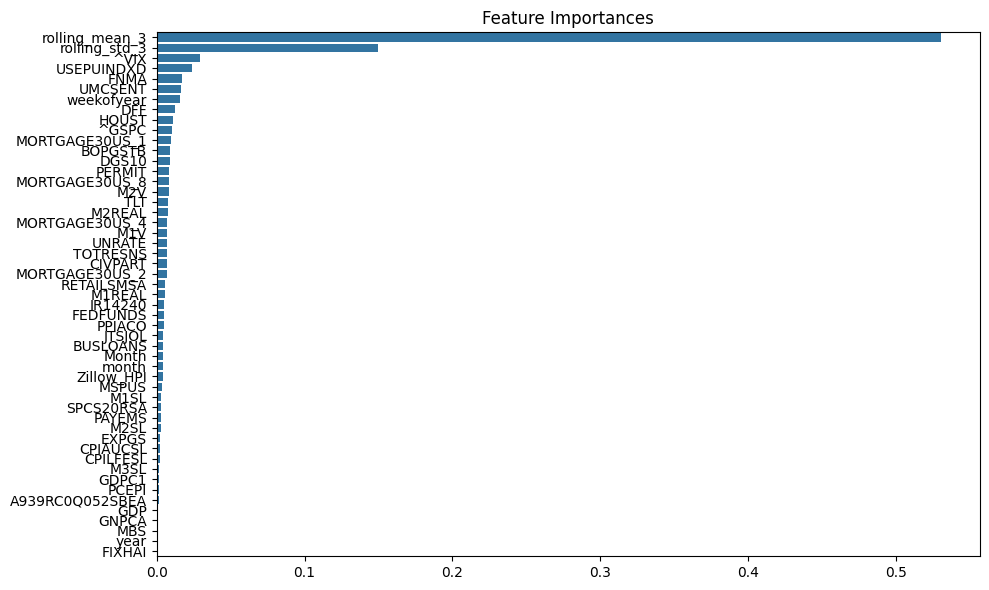

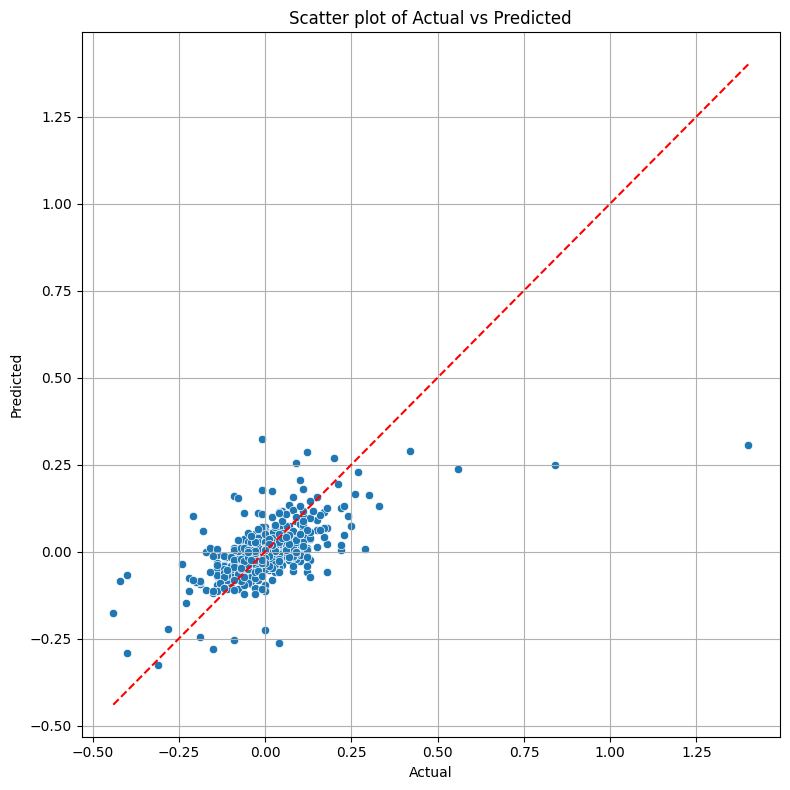

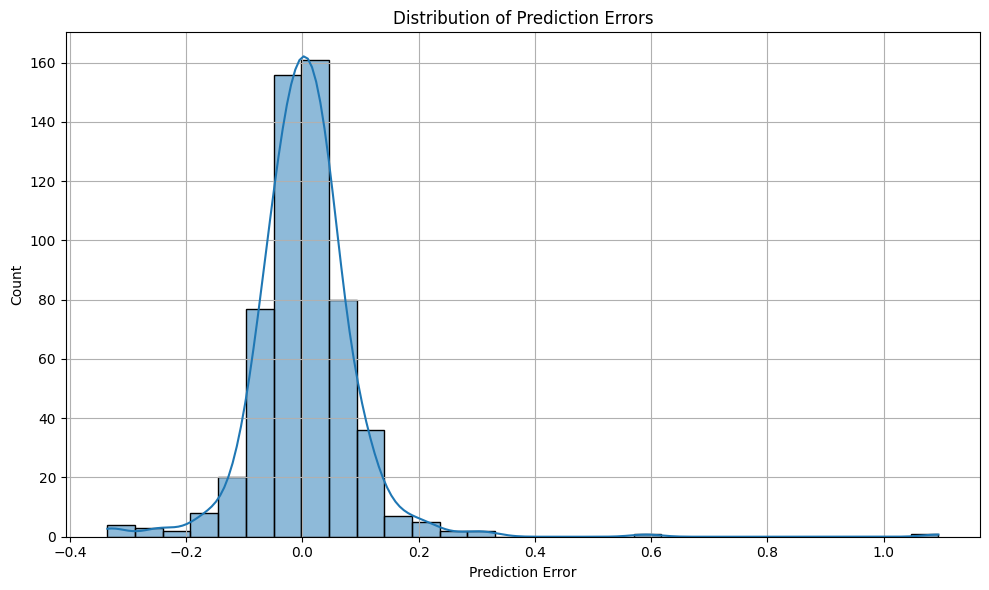

In [67]:
plot_feature_importance(model, X_train.columns.tolist())
plot_scatter_predictions(y_test, preds)
plot_error_distribution(y_test, preds)

In [ ]:
# tune_hyperparameters(model, X_train, y_train)